In [14]:
# Import required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.manifold import TSNE

from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers
import shap

In [2]:
# Load the data
df = pd.read_csv('creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
# Data Exploration
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
print(df['Class'].value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


Class is highly imabalanced

In [5]:
print(f"\nFraudulent Transaction Percentage: {100 * df['Class'].mean():.4f}%")


Fraudulent Transaction Percentage: 0.1727%


Exploratory Data Analysis

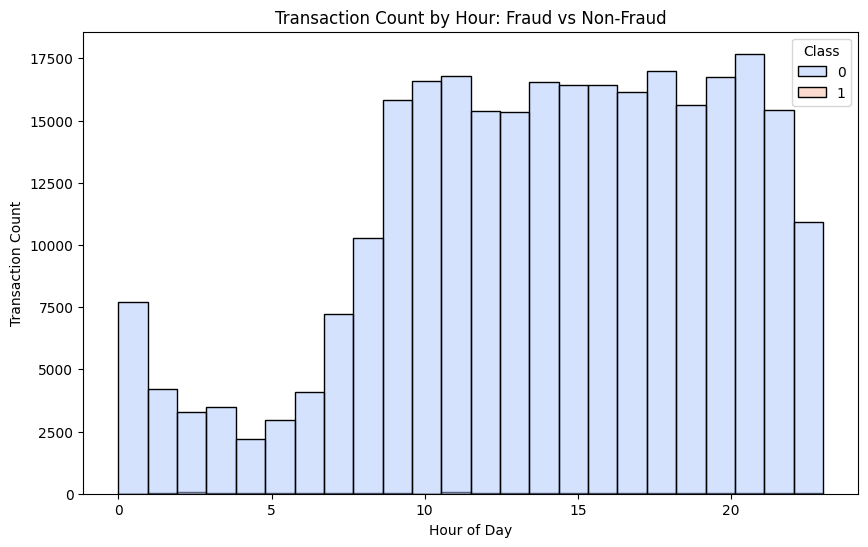

In [6]:
# Hourly Analysis
df['Hour'] = (df['Time'] // 3600) % 24
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Hour', hue='Class', bins=24, kde=False, palette='coolwarm')
plt.title("Transaction Count by Hour: Fraud vs Non-Fraud")
plt.xlabel("Hour of Day")
plt.ylabel("Transaction Count")
plt.show()

Observation:

*   Fraud transactions (red) occur sparsely compared to non-fraud transactions (blue).
*   Non-fraudulent transactions have clear peaks around 9 AM to 10 PM, indicating typical business activity hours.

Insight: This irregular behavior suggests that fraud detection should consider time-based anomalies—transactions occurring during off-peak hours (e.g., early morning hours like 1 AM–5 AM) might be worth closer investigation.

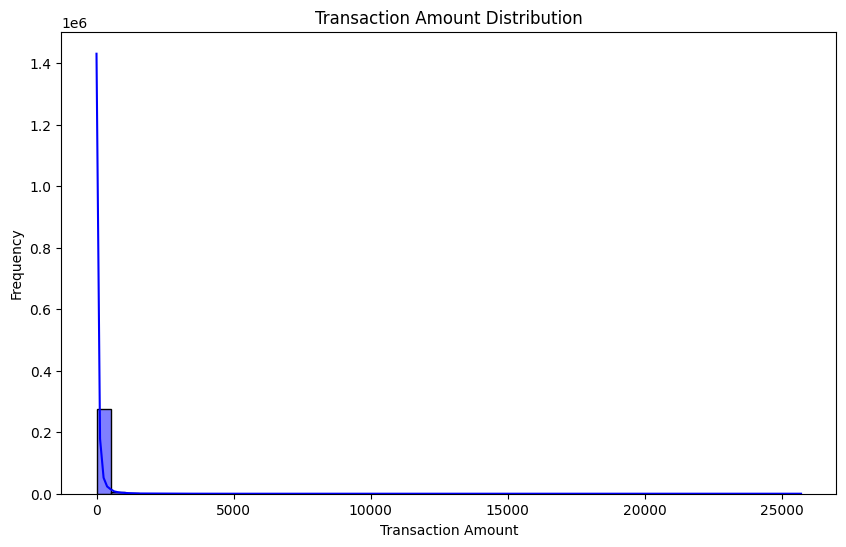

In [7]:
# Amount Distribution Analysis
plt.figure(figsize=(10, 6))
sns.histplot(df['Amount'], bins=50, color='blue', kde=True)
plt.title("Transaction Amount Distribution")
plt.xlabel("Transaction Amount")
plt.ylabel("Frequency")
plt.show()

Observations: The distribution of transaction amounts is heavily right-skewed.

*   The distribution of transaction amounts is heavily right-skewed.
*   Most transactions, including fraudulent ones, occur at low amounts (close to 0).
*   High-value transactions (>10,000) are extremely rare, and fraud transactions in this range are not prominent.

Insight: This highlights the importance of focusing on low to mid-range transaction values when detecting fraud.

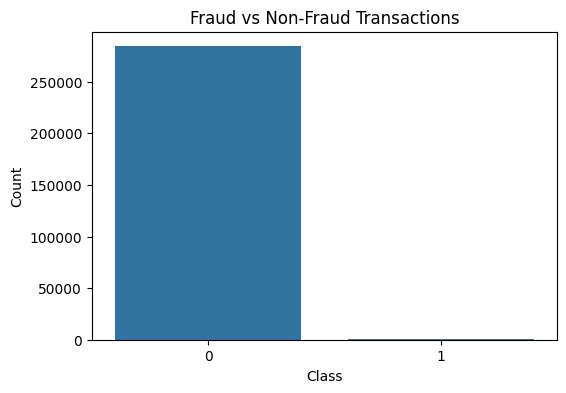

In [8]:
# Fraud vs Non-fraud transaction count
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=df)
plt.title("Fraud vs Non-Fraud Transactions")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

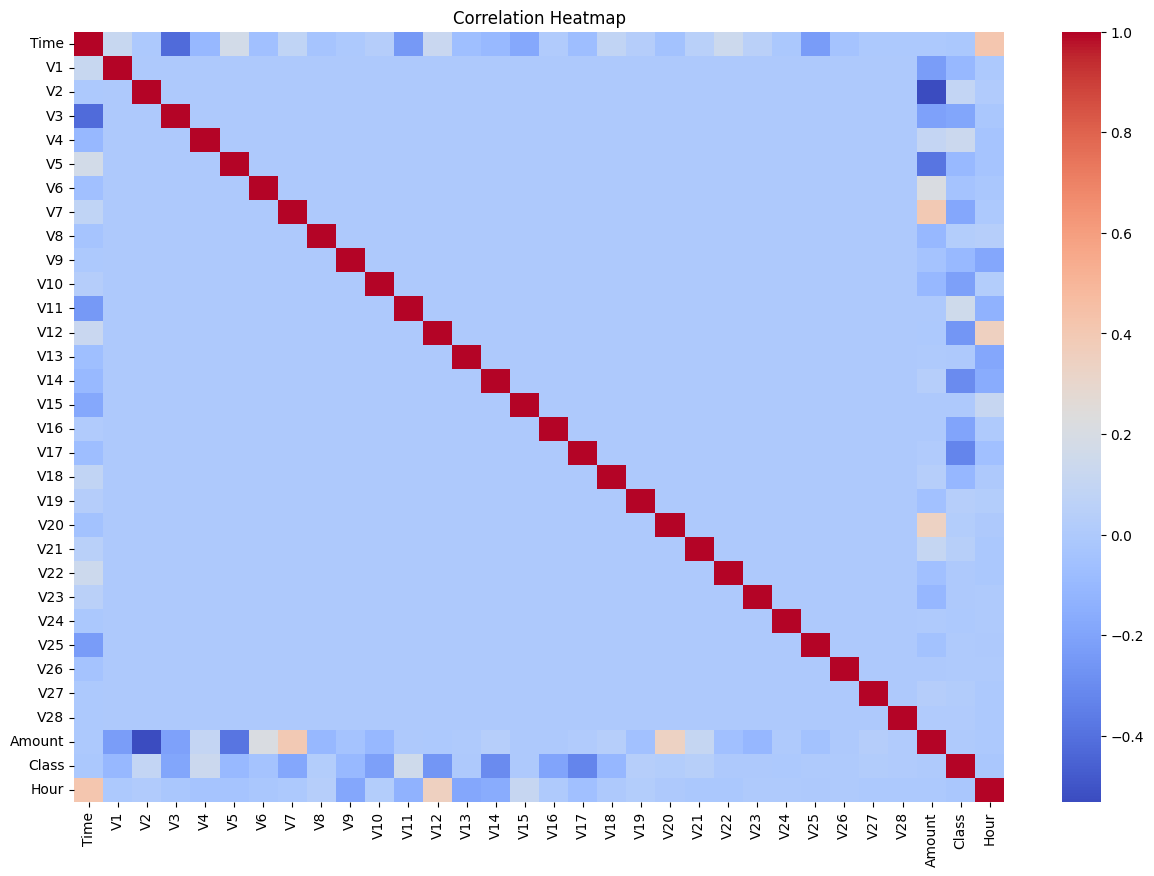

In [9]:
#correlation analysis among feature
correlation = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

Observation: The features are not showing any strong correlation relationship among themselves. So we do not have to remove any feature based on correlation analysis.

In [10]:
# Scaling and Sampling Data
X = df.drop(['Class', 'Time'], axis=1)
y = df['Class']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [11]:
# Undersampling for Imbalance Handling
rus = RandomUnderSampler(random_state=1)
X_resampled, y_resampled = rus.fit_resample(X_scaled, y)

In [12]:
X_resampled.shape, y_resampled.shape

((984, 30), (984,))

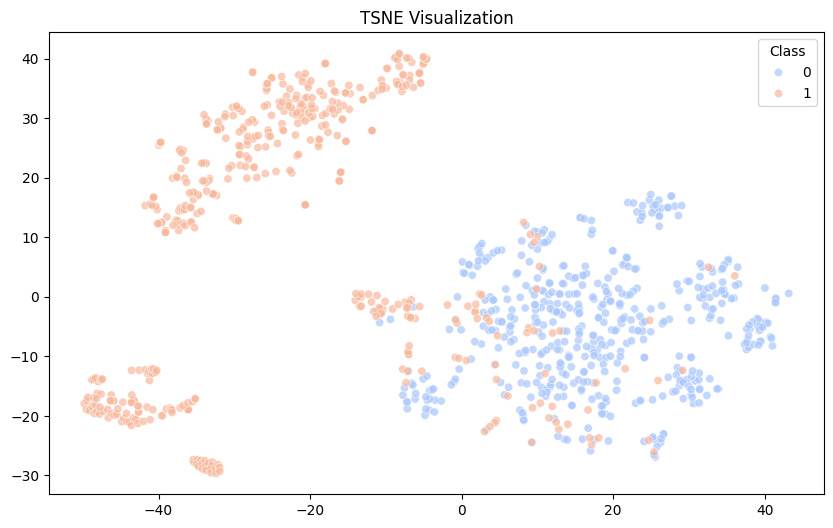

In [15]:
# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=24)
X_tsne = tsne.fit_transform(X_resampled)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_resampled, palette='coolwarm', alpha=0.7)
plt.title("TSNE Visualization")
plt.show()

In [16]:
#Constructing Autoencoder
input_dim = X_resampled.shape[1]  # Input dimension
encoding_dim_1 = 32  # First hidden layer dimension
encoding_dim_2 = 16  # Second hidden layer dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim_1, activation="relu")(input_layer)
encoder = Dense(encoding_dim_2, activation="relu")(encoder)

# Decoder
decoder = Dense(encoding_dim_1, activation="relu")(encoder)
decoder = Dense(input_dim, activation="sigmoid")(decoder)

# Autoencoder Model
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')  # Changed loss function to binary_crossentropy

In [17]:
# Training the Autoencoder
history = autoencoder.fit(X_resampled[y_resampled == 0],  # Train only on non-fraudulent data
                          X_resampled[y_resampled == 0],
                          epochs=50,  # Increased epochs
                          batch_size=256,
                          shuffle=True,
                          validation_split=0.2,
                          verbose=1)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 384ms/step - loss: 0.7207 - val_loss: 0.7104
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.7112 - val_loss: 0.7000
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.7004 - val_loss: 0.6901
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.6888 - val_loss: 0.6806
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.6804 - val_loss: 0.6714
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.6724 - val_loss: 0.6624
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.6617 - val_loss: 0.6534
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.6531 - val_loss: 0.6443
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 0.6431 - val_loss: 0.6349
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - loss: 0.6341 - val_loss: 0.6253
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - loss: 0.6237 - val_loss: 0.6151
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.6146 - val_loss: 0.

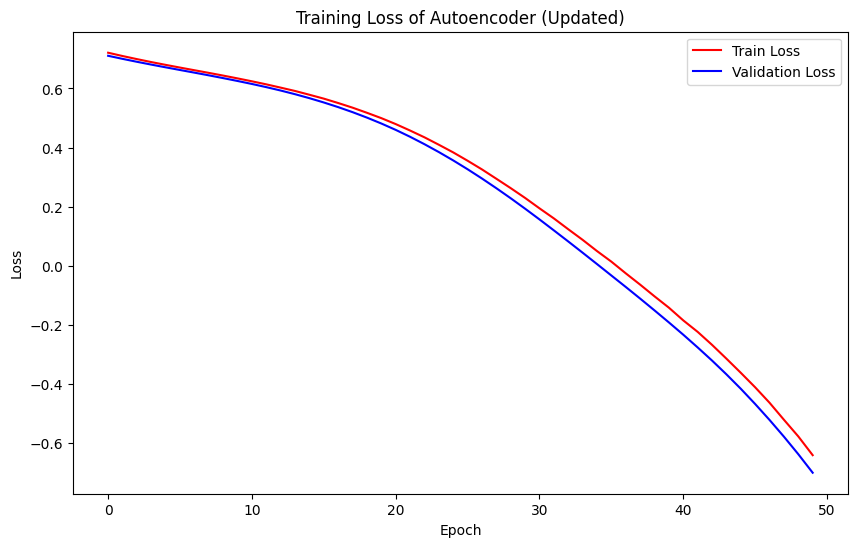

In [18]:
# Visualizing Training Loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='blue')
plt.title('Training Loss of Autoencoder (Updated)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [19]:
# Extracting Hidden Representations
encoder_model = Model(inputs=input_layer, outputs=encoder)
X_encoded = encoder_model.predict(X_resampled)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


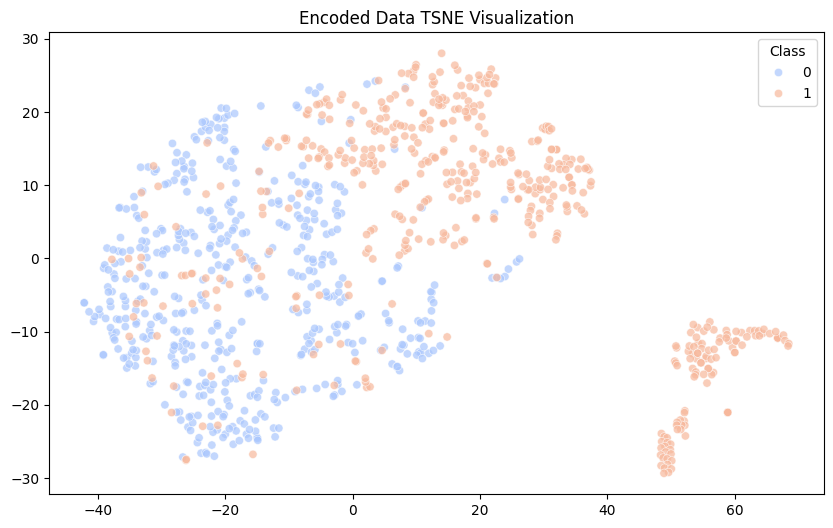

In [20]:
# TSNE on Encoded Data
X_tsne_encoded = tsne.fit_transform(X_encoded)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_tsne_encoded[:, 0], y=X_tsne_encoded[:, 1], hue=y_resampled, palette='coolwarm', alpha=0.7)
plt.title("Encoded Data TSNE Visualization")
plt.show()

The autoencoder is learning useful hidden representations since we observe some level of separation between fraudulent and non-fraudulent transactions.

In [21]:
# Train Test Split
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_resampled, test_size=0.3, random_state=1)

In [22]:
# Train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [23]:
# Evaluation Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       142
           1       0.94      0.88      0.91       154

    accuracy                           0.91       296
   macro avg       0.91      0.91      0.91       296
weighted avg       0.91      0.91      0.91       296

Confusion Matrix:
[[134   8]
 [ 19 135]]


In [24]:
# Train Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_logreg))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       142
           1       0.98      0.92      0.95       154

    accuracy                           0.95       296
   macro avg       0.95      0.95      0.95       296
weighted avg       0.95      0.95      0.95       296

Confusion Matrix:
[[139   3]
 [ 13 141]]


In [25]:
# Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)
y_pred_tree = dtree.predict(X_test)
print("Decision Tree:")
print(classification_report(y_test, y_pred_tree))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_tree))

Decision Tree:
              precision    recall  f1-score   support

           0       0.82      0.90      0.86       142
           1       0.90      0.81      0.85       154

    accuracy                           0.85       296
   macro avg       0.86      0.86      0.85       296
weighted avg       0.86      0.85      0.85       296

Confusion Matrix:
[[128  14]
 [ 29 125]]


Logistic Regression performs better

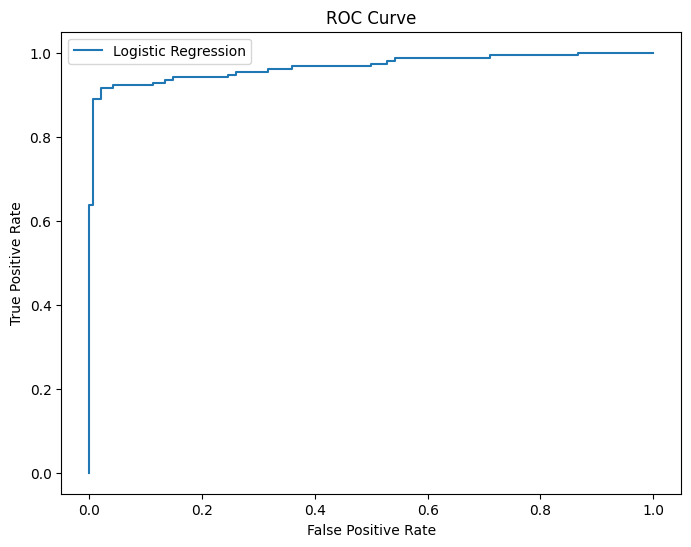

In [26]:
# Evaluation using ROC-AUC
fpr, tpr, _ = roc_curve(y_test, logreg.predict_proba(X_test)[:, 1])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [27]:
# Root Cause Analysis Using SHAP
explainer = shap.Explainer(logreg, X_train)
shap_values = explainer(X_test)

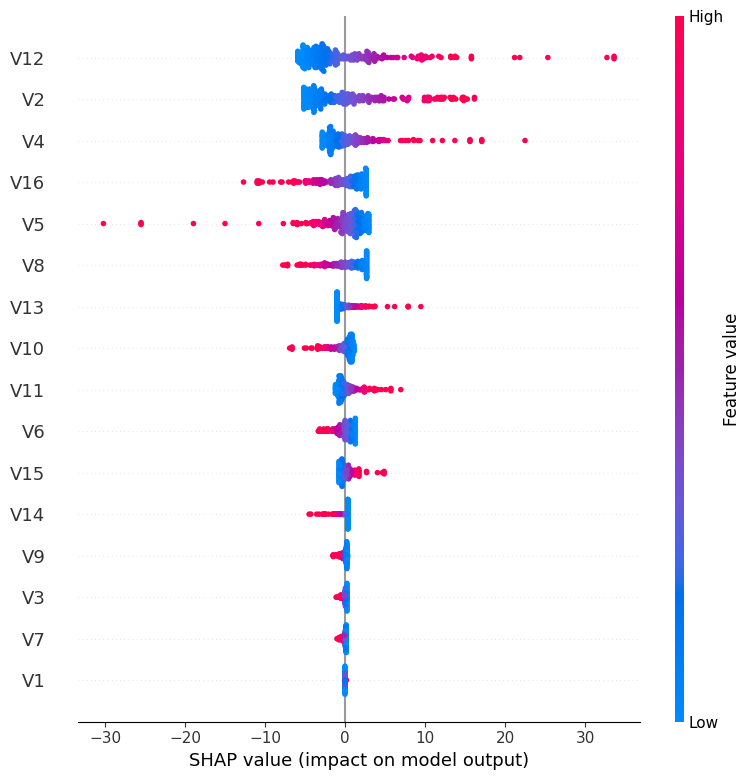

In [28]:
# Visualize Feature Importance
shap.summary_plot(shap_values, X_test, feature_names=df.columns.drop(['Class', 'Time']).tolist())

The most impactful features (from top to bottom) are V12, V2, V4, V16, V5, and others. These features are driving the model’s decisions to predict fraud or non-fraud.

Understanding SHAP:
The SHAP value (X-axis) indicates how much a feature pushes the model prediction towards fraud or non-fraud. Positive SHAP values → Push towards predicting fraud. And Negative SHAP values → Push towards predicting non-fraud. Here, most likely V12, V2, V4, V13, and V11 contributes significantly to increasing the fraud likelihood.
Red = High feature values and Blue = Low feature values.


Root Cause Analysis Insights:
Fraudulent transactions are strongly associated with specific patterns in feature values.
*   V12, V2, and V4 show clear relationships where high feature values increase the fraud probability.
*   V5 is another feature that stands out for certain transactions, possibly representing a characteristic behavior.

